In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

In [20]:
from scipy.special import legendre
def get_weights_for_delays(r):
    # compute the weights needed to extract the value at time r
    # from the network (r=0 is right now, r=1 is theta seconds ago)
    r = np.asarray(r)
    m = np.asarray([legendre(i)(2*r - 1) for i in range(q)])
    return m.reshape(q,-1).T

In [129]:
def make_lmu(q=6, theta=1.0):
    # Do Aaron's math to generate the matrices
    #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
    Q = np.arange(q, dtype=np.float64)
    R = (2*Q + 1)[:, None] / theta
    j, i = np.meshgrid(Q, Q)

    A = np.where(i < j, -1, (-1.)**(i-j+1)) * R
    B = (-1.)**Q[:, None] * R
    return A, B

q = 6
theta = 0.4
A, B = make_lmu(q=q, theta=theta)

period = 1.0
dt = 0.001

In [130]:
model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: 1 if 0.1<t%period<0.2 else 0)
    
    m = nengo.Node(None, size_in=q)
    nengo.Connection(m, m, synapse=0)
    nengo.Connection(stim, m, transform=B*dt, synapse=None)
    nengo.Connection(m, m, transform=A*dt, synapse=0)
    
    p_stim = nengo.Probe(stim)
    p_m = nengo.Probe(m)
sim = nengo.Simulator(model, dt=dt)
sim.run(period*2)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

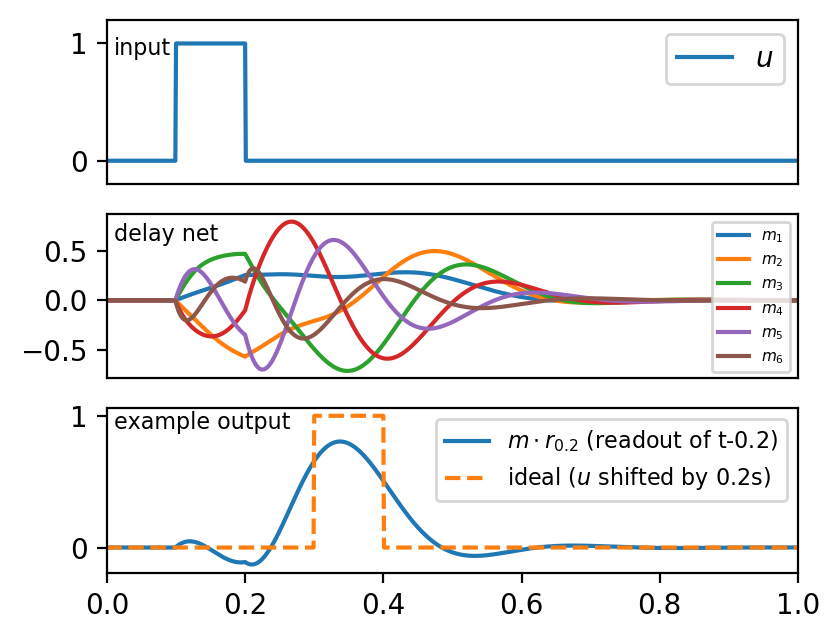

In [131]:
plt.figure(figsize=(4,3), dpi=200)
plt.subplot(3, 1, 1)
t = sim.trange()-period
plt.plot(t, sim.data[p_stim])
plt.xlim(0, period)
plt.ylim(-0.2, 1.2)
plt.xticks([])
plt.legend(['$u$'])
plt.text(0.01, 0.9, 'input', fontsize=8)

plt.subplot(3, 1, 2)

plt.plot(t, sim.data[p_m])
plt.xlim(0, period)
plt.xticks([])
plt.legend(['$m_%d$'%(i+1) for i in range(q)], fontsize=5.5, loc='upper right')
plt.text(0.01, 0.6, 'delay net', fontsize=8)

plt.subplot(3, 1, 3)
readout = get_weights_for_delays(0.5)
plt.plot(t, sim.data[p_m].dot(readout.T))
plt.plot(t+0.2, sim.data[p_stim], ls='--')
plt.xlim(0, period)
plt.legend(['$m \cdot r_{0.2}$ (readout of t-0.2)', 'ideal ($u$ shifted by 0.2s)'], fontsize=8)
plt.text(0.01, 0.9, 'example output', fontsize=8)

plt.tight_layout(pad=0)
plt.savefig('dn1-behaviour.png', dpi=600)
plt.savefig('dn1-behaviour.pdf', dpi=600)
plt.show()